In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from typing import Sequence, Dict, Tuple

from abm1559.utils import (
    constants,
)

gamma = 500000 # obtained from stats analysis of sample txs
constants["SIMPLE_TRANSACTION_GAS"] = gamma

from abm1559.txpool import TxPool

from abm1559.users import (
    User1559,
    User
)

from abm1559.config import rng

from abm1559.txs import Tx1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
    BlockAMMImplied,
    eth_qty,
)

from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
    generate_gbm,
    apply_block_time_variance,
    generate_poisson_process,
    generate_abm,
    generate_jump_process,
)

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import time
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product

Model assumptions:

- All transactions use 500,000 gas, block limit is 25,000,000 gas (i.e., 50 transactions).
- Simulation lasts for 200 steps.
- Each step, a random number of users $N_t$ is drawn from a Poisson distribution of size 100.
- User value is drawn from uniform distribution between 0 and 20 Gwei per gas unit.
- Users bid the miner fee as premium, = 1 Gwei.
- Excess gas issued starts from an arbitrary value set to 3,600 Mgas (~0.06 Gwei implied basefee)
- Implied basefee in a block providing `gas_used`, given `excess_gas_issued` is

$$ b = \frac{\text{ethqty}(\text{excess gas issued} + \text{gas used}) - \text{ethqty}(\text{excess gas issued})}{\text{gas used}} $$

where

$$ \text{ethqty}(g) = \exp \Big( \frac{g}{\text{target gas used} \times \text{adjustment quotient}} \Big) $$

## Transaction pool

- Evicts transactions whenever there are more than 500 pending in the queue (reminder: we set transaction such that a full block = 50 transactions)
- Given the current `excess_gas_issued`, miner computes their revenue should they include 0 transaction, 1 transaction, 2 transactions, ..., 50 transactions. Number of transactions included is set so that max revenue is achieved.

In [2]:
MAX_TX_POOL = 500
MIN_PREMIUM = 1e9

class TxPoolLimit(TxPool):
    
    def __init__(self, max_txs=MAX_TX_POOL, min_premium=MIN_PREMIUM, **kwargs):
        super().__init__(**kwargs)
        self.max_txs = max_txs
        self.min_premium = MIN_PREMIUM
    
    def add_txs(self, txs: Sequence[Tx1559], env: dict) -> Sequence[Tx1559]:
        for tx in txs:
            self.txs[tx.tx_hash] = tx
                    
        if self.pool_length() > self.max_txs:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:self.max_txs], env)
            return sorted_txs[self.max_txs:]
        
        return []

class TxPool1559(TxPoolLimit):
    
    def select_transactions(self, env, user_pool=None, rng=rng) -> Sequence[Tx1559]:
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= self.min_premium]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

class TxPoolAMMImplied(TxPoolLimit):
    
    def select_transactions(self, env, user_pool=None, rng=rng) -> Sequence[Tx1559]:
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
        excess_gas_issued = env["excess_gas_issued"]
        revenues = [0]
        
        for i in range(1, max_tx_in_block + 1):        
            implied_basefee = eth_qty(excess_gas_issued + i * constants["SIMPLE_TRANSACTION_GAS"]) - eth_qty(excess_gas_issued)
            implied_basefee = implied_basefee / (i * constants["SIMPLE_TRANSACTION_GAS"])
            valid_txs = [tx for tx in self.txs.values() if tx.is_valid({ "basefee": implied_basefee }) and tx.tip({ "basefee": implied_basefee }) >= self.min_premium]
            sorted_valid_demand = sorted(
                valid_txs,
                key = lambda tx: -tx.tip({ "basefee": implied_basefee })
            )
            revenues += [sum([tx.tip({ "basefee": implied_basefee }) for tx in sorted_valid_demand[0:(i-1)]])]
        
        max_revenue = max(revenues)
        
        if max_revenue == 0:
            return []
        
        opt_n_tx = len(revenues) - 1 - revenues[::-1].index(max_revenue)
        implied_basefee = eth_qty(excess_gas_issued + opt_n_tx * constants["SIMPLE_TRANSACTION_GAS"]) - eth_qty(excess_gas_issued)
        implied_basefee = implied_basefee / (opt_n_tx * constants["SIMPLE_TRANSACTION_GAS"])
        valid_txs = [tx for tx in self.txs.values() if tx.is_valid({ "basefee": implied_basefee }) and tx.tip({ "basefee": implied_basefee }) >= self.min_premium]
        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip({ "basefee": implied_basefee })
        )
        selected_txs = sorted_valid_demand[0:opt_n_tx]

        return selected_txs

## Main simulation loop

In [3]:
def simulate_amm_implied(demand_scenario, txpool, UserClass, extra_metrics = None, rng = rng, silent=False):
    # Instantiate a couple of things
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    block_target = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"] / 2.0)
    
    # `env` is the "environment" of the simulation
    env = {
        "basefee": 0,
        "current_block": None,
        "excess_gas_issued": 3625 * 1e6,
    }

    for t in tqdm(range(len(demand_scenario)), disable=silent, desc="simulation loop", leave=False):
        if demand_scenario[t] > 5 * MAX_TX_POOL:
            break
        
        # Sets current block
        env["current_block"] = t
        
        # Reset the random number generator with new seed to generate users with same values across runs
        rng = np.random.default_rng((2 ** t) * (3 ** 1))
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_demand(t, demand_scenario[t], User1559, rng=rng)
        
        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        # `evicted_txs` holds the transactions removed from the pool for lack of space
        pool_limit_evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env, rng = rng)
        
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = BlockAMMImplied(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, excess_gas_issued = env["excess_gas_issued"]
        )
        
        env["excess_gas_issued"] = max(0, env["excess_gas_issued"] + block.gas_used() - constants["TARGET_GAS_USED"])
        env["basefee"] = eth_qty(env["excess_gas_issued"])
        env["basefee"] = env["basefee"] / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"] / constants["TARGET_GAS_USED"]
        
        # The block is added to the chain
        chain.add_block(block)
        
        ### METRICS ###                
        row_metrics = {
            "block": t,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "pool_limit_evictions": len(pool_limit_evicted_txs),
            "included_txs": len(selected_txs),
            "basefee": env["basefee"] / 1e9, # to Gwei
            "excess_gas_issued": env["excess_gas_issued"] / 1e6, # in Mgas
            "pool_length": txpool.pool_length(),
            "gas_used": block.gas_used(),
        }
        
        if not extra_metrics is None:
            row_metrics = {
                **row_metrics,
                **extra_metrics(env, users, user_pool, txpool),
            }
        
        metrics.append(row_metrics)

    return (pd.DataFrame(metrics), user_pool, chain)

In [4]:
%%capture
demand_scenario = [100 for i in range(200)]
txpool = TxPoolAMMImplied()
(df, user_pool, chain) = simulate_amm_implied(demand_scenario, txpool, User1559)

## Plots

### Basefee over time

<AxesSubplot:>

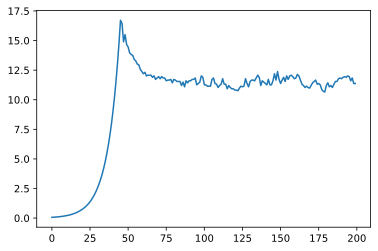

In [5]:
df["basefee"].plot()

### Transaction pool over time

<AxesSubplot:>

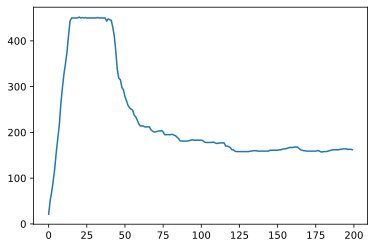

In [6]:
df["pool_length"].plot()

### Excess gas issued over time

<AxesSubplot:>

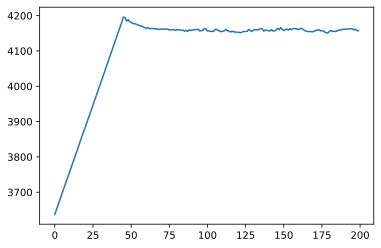

In [7]:
df["excess_gas_issued"].plot()

## Oscillations revisited

- Users have value between 10 and 11 Gwei per gas unit.
- 1000 users show up each step.

In [8]:
class NarrowUser(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.uniform(low=10, high=11) * (10 ** 9)

### With AMM design

In [9]:
%%capture
demand_scenario = [1000 for i in range(200)]
txpool = TxPoolAMMImplied()
(df_amm, _, _) = simulate_amm_implied(demand_scenario, txpool, NarrowUser)

#### Basefee over time

<AxesSubplot:>

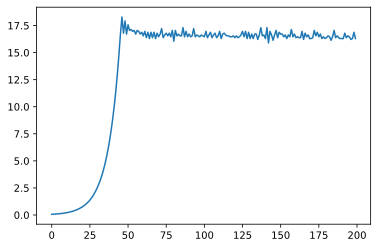

In [10]:
df_amm["basefee"].plot()

#### Gas used per block

<AxesSubplot:>

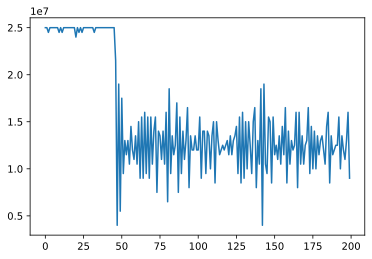

In [11]:
df_amm["gas_used"].plot()

### With classic 1559

In [12]:
def simulate_1559(demand_scenario, txpool, UserClass, extra_metrics = None, rng = rng, silent=False):
    # Instantiate a couple of things
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    block_target = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"] / 2.0)
    
    # `env` is the "environment" of the simulation
    env = {
        "basefee": 0.06 * 1e9,
        "current_block": None,
    }

    for t in tqdm(range(len(demand_scenario)), disable=silent, desc="simulation loop", leave=False):
        if demand_scenario[t] > 5 * MAX_TX_POOL:
            break
        
        # Sets current block
        env["current_block"] = t
        
        # Reset the random number generator with new seed to generate users with same values across runs
        rng = np.random.default_rng((2 ** t) * (3 ** 1))
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_demand(t, demand_scenario[t], User1559, rng=rng)
        
        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        # `evicted_txs` holds the transactions removed from the pool for lack of space
        pool_limit_evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env, rng = rng)
        
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, basefee = env["basefee"]
        )
        
        # The block is added to the chain
        chain.add_block(block)
        
        ### METRICS ###                
        row_metrics = {
            "block": t,
            "users": len(users),
            "decided_txs": len(decided_txs),
            "pool_limit_evictions": len(pool_limit_evicted_txs),
            "included_txs": len(selected_txs),
            "basefee": env["basefee"] / 1e9, # to Gwei
            "pool_length": txpool.pool_length(),
            "gas_used": block.gas_used(),
        }
        
        if not extra_metrics is None:
            row_metrics = {
                **row_metrics,
                **extra_metrics(env, users, user_pool, txpool),
            }
        
        metrics.append(row_metrics)
        
        # Finally, basefee is updated and a new round starts
        env["basefee"] = update_basefee(block, env["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)

In [13]:
%%capture
demand_scenario = [1000 for i in range(200)]
txpool = TxPool1559()
(df_1559, _, _) = simulate_1559(demand_scenario, txpool, NarrowUser)

#### Basefee over time

<AxesSubplot:>

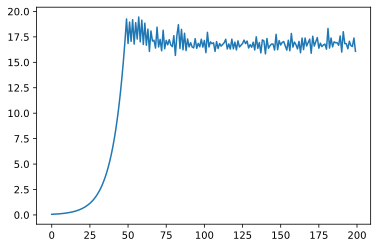

In [14]:
df_1559["basefee"].plot()

#### Gas used per block

<AxesSubplot:>

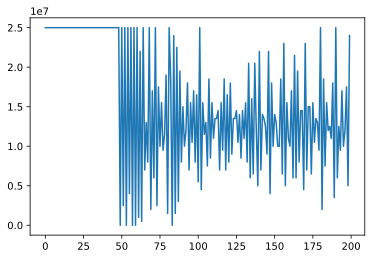

In [15]:
df_1559["gas_used"].plot()

Oscillations do seem more violent in the classic 1559 case, though they do not completely disappear with the AMM design.